In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.4 MB/s eta 0:00:00


In [10]:
import torch
import wandb
import transformers
import pandas as pd
import matplotlib.pyplot as plt
from transformers import pipeline
import seaborn as sns
from collections import Counter
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from datasets import Dataset as HFDataset

In [ ]:
df = pd.read_csv("training_data.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    120000 non-null  object
 1   label   120000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ MB


In [ ]:
df.head()

,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2


In [6]:
df["label"].unique()

array([2, 3, 1, 0])

<ipython-input-7-ecb97909580e>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["label"], palette="viridis")


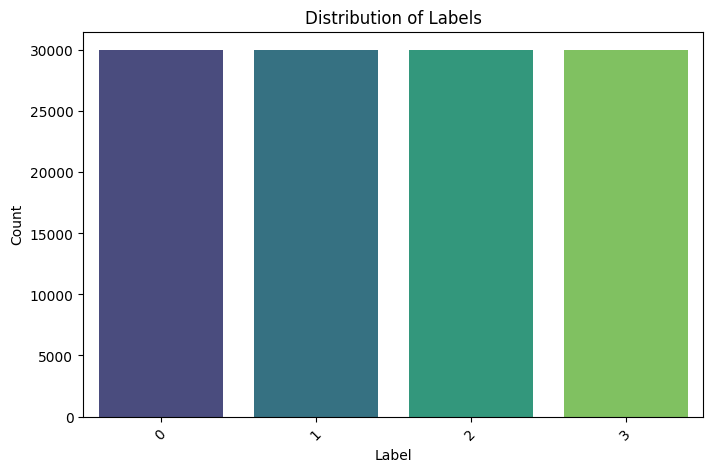

In [7]:
plt.figure(figsize=(8, 5))
sns.countplot(x=df["label"], palette="viridis")
plt.title("Distribution of Labels")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

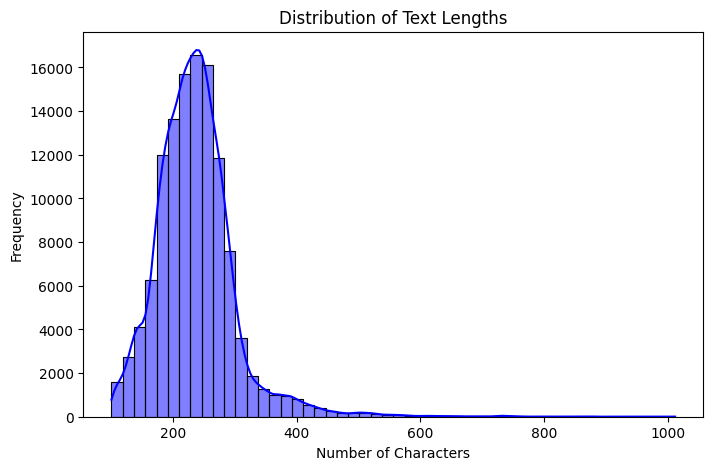

In [8]:
# Text length analysis
df["text_length"] = df["text"].apply(len)

plt.figure(figsize=(8, 5))
sns.histplot(df["text_length"], bins=50, kde=True, color="blue")
plt.title("Distribution of Text Lengths")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.show()

In [9]:
text_length_summary = df["text_length"].describe()
text_length_summary

,text_length
count,120000.000000
mean,236.477525
std,66.509741
min,100.000000
25%,196.000000
50%,232.000000
75%,266.000000
max,1012.000000


Some observations from visual data analysis

*   Dataset has 4 labels 0,1,2,3
*   Each label appears 30,000 times which seems to be balanced and might not cause bias during training
*   Most of the text seems to have length of  approximately 200-250
*   There are no text of length 0-100 so we dont need to remove anything
*   Some are of length 1000+ which means we might need to truncate or handel later on during training.




In [11]:
wandb.init(project="Lalas-distilbert")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: younesh-kc (oi-ai) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [15]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [16]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [25]:
def tokenize_data(df):
    return tokenizer(df['text'].tolist(), padding=True, truncation=True, max_length=256, return_tensors="pt")

In [26]:
train_encodings = tokenize_data(train_df)
val_encodings = tokenize_data(val_df)

In [27]:
train_labels = torch.tensor(train_df['label'].tolist())
val_labels = torch.tensor(val_df['label'].tolist())

In [28]:
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

In [29]:
train_dataset = TextDataset(train_encodings, train_labels)
val_dataset = TextDataset(val_encodings, val_labels)

In [30]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=4)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [69]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    learning_rate=4e-5,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=500,
    evaluation_strategy="epoch",
    fp16=False,  # Enabling mixed precision training
    report_to="wandb"  # Enable WandB logging
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [65]:
!rm -rf results/

In [70]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

In [71]:
trainer.train()##batch size 64 with mixed prescision False

Epoch,Training Loss,Validation Loss
1,0.018600,0.340610
2,0.014000,0.376332
3,0.005500,0.429874


TrainOutput(global_step=4500, training_loss=0.014801525645785862, metrics={'train_runtime': 1816.1813, 'train_samples_per_second': 158.574, 'train_steps_per_second': 2.478, 'total_flos': 1.9075985768448e+16, 'train_loss': 0.014801525645785862, 'epoch': 3.0})

In [56]:
trainer.train()#batch size 64

Epoch,Training Loss,Validation Loss
1,0.050400,0.271981
2,0.031200,0.284132
3,0.009600,0.351684


TrainOutput(global_step=4500, training_loss=0.026784879048665364, metrics={'train_runtime': 1748.4097, 'train_samples_per_second': 164.721, 'train_steps_per_second': 2.574, 'total_flos': 1.9075985768448e+16, 'train_loss': 0.026784879048665364, 'epoch': 3.0})

In [60]:
model.save_pretrained('./distilbert-finetuned03')
tokenizer.save_pretrained('./distilbert-finetuned03')

('./distilbert-finetuned03/tokenizer_config.json',
 './distilbert-finetuned03/special_tokens_map.json',
 './distilbert-finetuned03/vocab.txt',
 './distilbert-finetuned03/added_tokens.json')

In [ ]:
trainer.train()#batch size 64

In [47]:
trainer.train()#batch size 32

Epoch,Training Loss,Validation Loss
1,0.097800,0.223135
2,0.082900,0.212554
3,0.030000,0.287276


TrainOutput(global_step=9000, training_loss=0.06774557452731662, metrics={'train_runtime': 2124.456, 'train_samples_per_second': 135.564, 'train_steps_per_second': 4.236, 'total_flos': 1.9075985768448e+16, 'train_loss': 0.06774557452731662, 'epoch': 3.0})

In [49]:
# Evaluate the model
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

Evaluation results: {'eval_loss': 0.2872757911682129, 'eval_runtime': 46.3006, 'eval_samples_per_second': 518.352, 'eval_steps_per_second': 16.198, 'epoch': 3.0}


In [51]:
model.save_pretrained('./distilbert-finetuned')
tokenizer.save_pretrained('./distilbert-finetuned')

('./distilbert-finetuned/tokenizer_config.json',
 './distilbert-finetuned/special_tokens_map.json',
 './distilbert-finetuned/vocab.txt',
 './distilbert-finetuned/added_tokens.json')

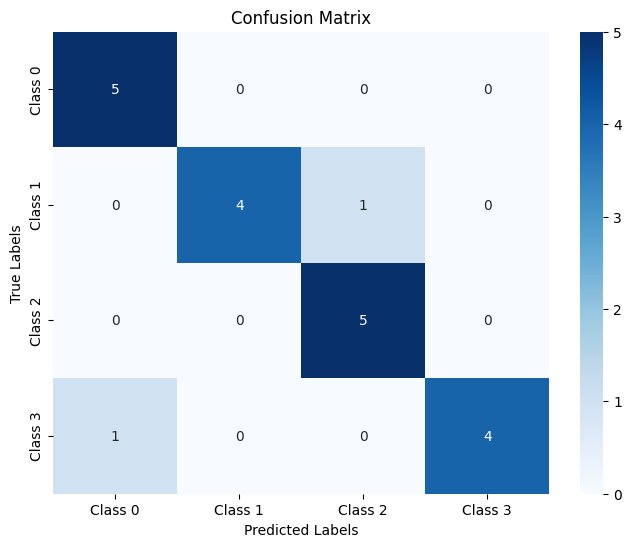

Accuracy: 0.9000
Precision (Macro): 0.9167
Recall (Macro): 0.9000
F1-Score (Macro): 0.8990
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.83      1.00      0.91         5
     Class 1       1.00      0.80      0.89         5
     Class 2       0.83      1.00      0.91         5
     Class 3       1.00      0.80      0.89         5

    accuracy                           0.90        20
   macro avg       0.92      0.90      0.90        20
weighted avg       0.92      0.90      0.90        20



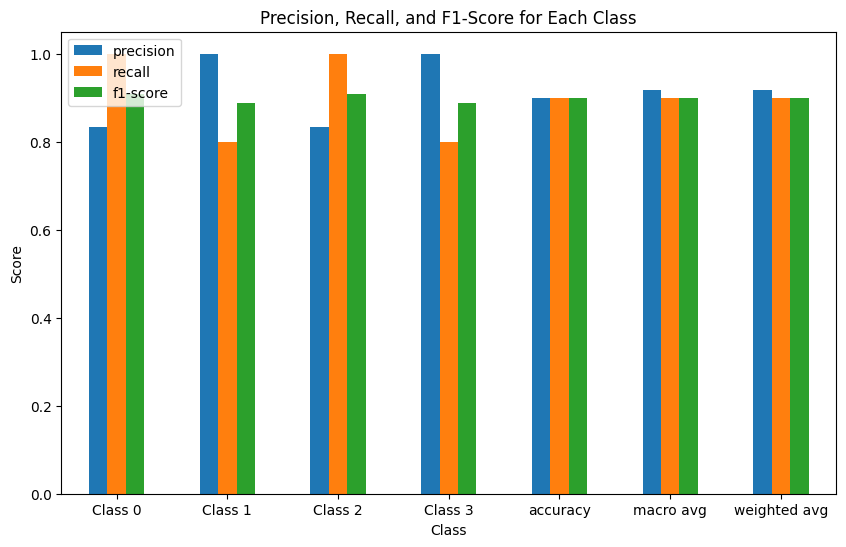

In [52]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# Load the fine-tuned model and tokenizer
model_path = './distilbert-finetuned'  # Path to the saved model
tokenizer = DistilBertTokenizer.from_pretrained(model_path)
model = DistilBertForSequenceClassification.from_pretrained(model_path)

# Set the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()  # Set the model to evaluation mode


val_df = pd.read_csv('test_data.csv')
val_texts = val_df['text'].tolist()
val_labels = val_df['label'].tolist()

# Tokenize the validation data
val_encodings = tokenizer(val_texts, padding=True, truncation=True, max_length=512, return_tensors="pt")
val_input_ids = val_encodings['input_ids'].to(device)
val_attention_mask = val_encodings['attention_mask'].to(device)

# Perform inference on the validation dataset
with torch.no_grad():
    outputs = model(val_input_ids, attention_mask=val_attention_mask)
    logits = outputs.logits
    predicted_labels = torch.argmax(logits, dim=-1).cpu().numpy()

# Compute evaluation metrics
true_labels = np.array(val_labels)
predicted_labels = np.array(predicted_labels)

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1", "Class 2", "Class 3"], yticklabels=["Class 0", "Class 1", "Class 2", "Class 3"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")

# Precision, Recall, F1-Score (macro-averaged)
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')

print(f"Precision (Macro): {precision:.4f}")
print(f"Recall (Macro): {recall:.4f}")
print(f"F1-Score (Macro): {f1:.4f}")

# Classification Report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=["Class 0", "Class 1", "Class 2", "Class 3"]))

# Plot Precision, Recall, F1-Score for Each Class
metrics = classification_report(true_labels, predicted_labels, target_names=["Class 0", "Class 1", "Class 2", "Class 3"], output_dict=True)
metrics_df = pd.DataFrame(metrics).transpose()

# Drop the 'support' row
metrics_df = metrics_df.drop('support', errors='ignore')

# Plot
metrics_df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10, 6))
plt.title("Precision, Recall, and F1-Score for Each Class")
plt.xlabel("Class")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.show()